
=== Exécution pour N = 100 objets ===

=== Exécution pour N = 200 objets ===

=== Exécution pour N = 300 objets ===

=== Exécution pour N = 400 objets ===

=== Exécution pour N = 500 objets ===

=== Exécution pour N = 600 objets ===

=== Exécution pour N = 700 objets ===

=== Exécution pour N = 800 objets ===

=== Exécution pour N = 900 objets ===

=== Exécution pour N = 1000 objets ===

===== TABLEAU DES TEMPS =====
   N   DP_time  Greedy_time  Genetic_time
 100  1.843814     0.001131      4.880187
 200  3.628275     0.001785      4.924651
 300  5.370733     0.002470      4.957177
 400  7.171483     0.003835      4.981793
 500  8.878023     0.003972      5.045809
 600 10.732249     0.005208      5.091011
 700 12.526443     0.005925      5.138455
 800 14.125623     0.006527      5.128777
 900 15.997934     0.007186      5.175741
1000 17.458390     0.007939      5.204943

===== TABLEAU MEMOIRE (Mo) =====
   N   DP_mem  Greedy_mem  Genetic_mem
 100 0.152393    0.006943     0.043153
 200

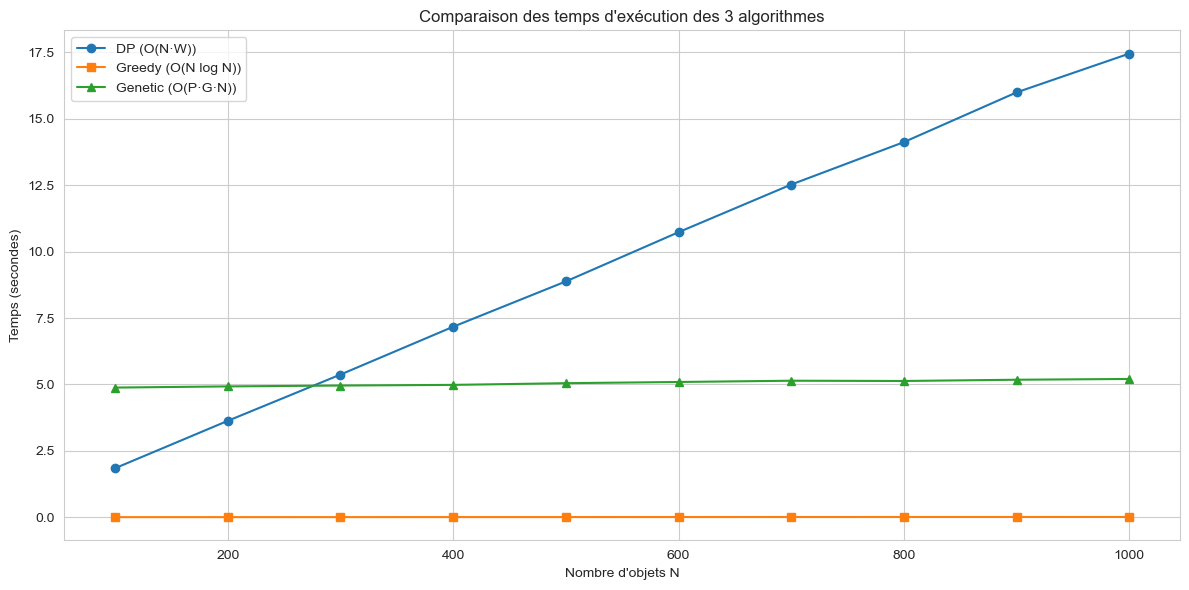

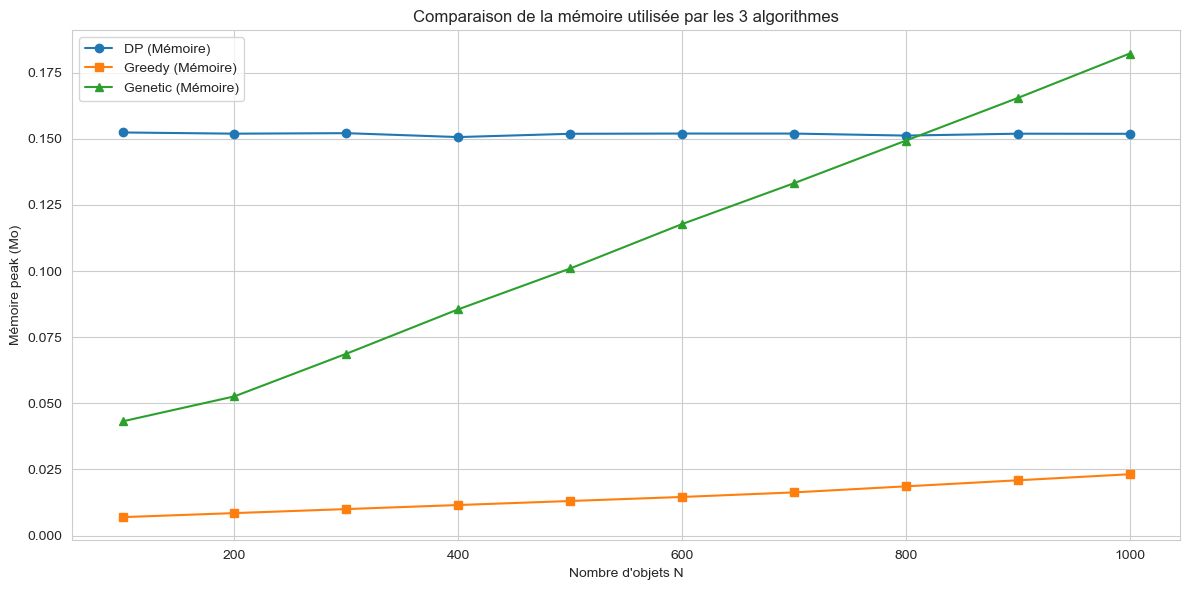

In [34]:
import numpy as np
import pandas as pd
import time
import tracemalloc
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# PARAMÈTRES
# -----------------------------------------------------------
N_TESTS = np.linspace(10, 100, 10, dtype=int) * 10   # N = 100 → 1000
W = 1000                                             # Capacité fixe
COMPLEXITY_LIMIT = 300_000_000                       # Limite DP

# -----------------------------------------------------------
# GÉNÉRATION ALÉATOIRE
# -----------------------------------------------------------
def generate_instance(n, W):
    w = np.random.randint(1, W//10, size=n)
    v = np.random.randint(10, 100, size=n)
    return w, v

# -----------------------------------------------------------
# KNAPSACK : PROGRAMMATION DYNAMIQUE
# -----------------------------------------------------------
def knapsack_dp(w, v, W):
    tracemalloc.start()
    start = time.perf_counter()

    dp = np.zeros(W+1, dtype=int)
    for i in range(len(w)):
        for j in range(W, w[i]-1, -1):
            dp[j] = max(dp[j], dp[j-w[i]] + v[i])

    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return time.perf_counter() - start, peak/1024**2

# -----------------------------------------------------------
# KNAPSACK : GREEDY
# -----------------------------------------------------------
def knapsack_greedy(w, v, W):
    tracemalloc.start()
    start = time.perf_counter()

    ratio = v / w
    idx = np.argsort(ratio)[::-1]

    tw = 0
    for i in idx:
        if tw + w[i] <= W:
            tw += w[i]

    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return time.perf_counter() - start, peak/1024**2

# -----------------------------------------------------------
# KNAPSACK : GÉNÉTIQUE
# -----------------------------------------------------------
def knapsack_genetic(w, v, W, pop=80, gens=150):
    n = len(w)
    tracemalloc.start()
    start = time.perf_counter()

    population = [np.random.randint(0, 2, n, dtype=bool) for _ in range(pop)]

    def fitness(ind):
        total_w = w[ind].sum()
        return 0 if total_w > W else v[ind].sum()

    for _ in range(gens):
        scores = np.array([fitness(ind) for ind in population])
        parents = np.argsort(scores)[-max(2, pop//4):]

        new_pop = []
        for _ in range(pop):
            p1 = population[np.random.choice(parents)]
            p2 = population[np.random.choice(parents)]
            mask = np.random.rand(n) < 0.5
            child = (mask & p1) | (~mask & p2)

            if np.random.rand() < 0.05:
                child[np.random.randint(0, n)] ^= True

            new_pop.append(child)

        population = new_pop

    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return time.perf_counter() - start, peak/1024**2

# -----------------------------------------------------------
# TESTS
# -----------------------------------------------------------
results = {
    "N": [],
    "DP_time": [], "Greedy_time": [], "Genetic_time": [],
    "DP_mem": [], "Greedy_mem": [], "Genetic_mem": []
}

for N in N_TESTS:
    print(f"\n=== Exécution pour N = {N} objets ===")
    w, v = generate_instance(N, W)
    
    results["N"].append(N)

    # DP
    if N * W < COMPLEXITY_LIMIT:
        t_dp, m_dp = knapsack_dp(w, v, W)
    else:
        t_dp, m_dp = np.nan, np.nan
    results["DP_time"].append(t_dp)
    results["DP_mem"].append(m_dp)

    # Greedy
    t_g, m_g = knapsack_greedy(w, v, W)
    results["Greedy_time"].append(t_g)
    results["Greedy_mem"].append(m_g)

    # Genetic
    t_ga, m_ga = knapsack_genetic(w, v, W)
    results["Genetic_time"].append(t_ga)
    results["Genetic_mem"].append(m_ga)

# -----------------------------------------------------------
# TABLEAUX
# -----------------------------------------------------------
df = pd.DataFrame(results)

print("\n===== TABLEAU DES TEMPS =====")
print(df[["N","DP_time","Greedy_time","Genetic_time"]].to_string(index=False))

print("\n===== TABLEAU MEMOIRE (Mo) =====")
print(df[["N","DP_mem","Greedy_mem","Genetic_mem"]].to_string(index=False))

# -----------------------------------------------------------
# GRAPHIQUE 1 : TEMPS
# -----------------------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(df["N"], df["DP_time"], marker='o', label="DP (O(N·W))")
plt.plot(df["N"], df["Greedy_time"], marker='s', label="Greedy (O(N log N))")
plt.plot(df["N"], df["Genetic_time"], marker='^', label="Genetic (O(P·G·N))")

plt.title("Comparaison des temps d'exécution des 3 algorithmes")
plt.xlabel("Nombre d'objets N")
plt.ylabel("Temps (secondes)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# GRAPHIQUE 2 : MEMOIRE
# -----------------------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(df["N"], df["DP_mem"], marker='o', label="DP (Mémoire)")
plt.plot(df["N"], df["Greedy_mem"], marker='s', label="Greedy (Mémoire)")
plt.plot(df["N"], df["Genetic_mem"], marker='^', label="Genetic (Mémoire)")

plt.title("Comparaison de la mémoire utilisée par les 3 algorithmes")
plt.xlabel("Nombre d'objets N")
plt.ylabel("Mémoire peak (Mo)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
